Hamiltonian:
   (1) [Z0 Z1]
state(wires=[0])


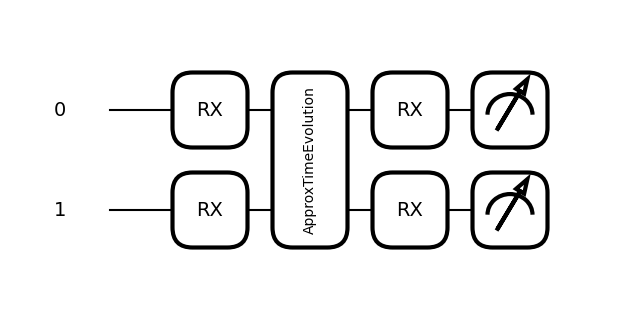

In [193]:
import matplotlib.pyplot as plt
import pennylane as qml
import scipy as sp

from pennylane import numpy as np
from IPython.display import display, Math

np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions()

dev = qml.device('default.qubit', wires= 2)

pauli_y = np.array([ [0, -1.j], [1.j, 0]])


# Hamiltonian setup
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
# print('Data type:', type(obs))


hamiltonian = qml.Hamiltonian(coeffs, obs)

print('Hamiltonian:\n', hamiltonian)

# Quantum circuit
@qml.qnode(dev)
def circuit(theta_1, theta_2, tau_ham):
    
	# """
	# qml.RX(theta_1,  wires = 0)    
	# qml.RX(theta_1, wires = 1)    
	qml.RX(np.pi/2, wires = 0)    
	qml.RX(np.pi/2, wires = 1)    
	
	qml.ApproxTimeEvolution(hamiltonian, tau_ham, 1)
	
	# qml.RX(theta_2, wires = 0)    
	# qml.RX(theta_2, wires = 1) 
	qml.RX(np.pi/2, wires = 0)    
	qml.RX(np.pi/2, wires = 1)
	
	# """
 
	"""
	qml.Hadamard(wires=0) 
	qml.CNOT(wires=[0,1])
 	"""

	return qml.density_matrix(wires=[0, 1])

print(qml.density_matrix(wires=0))
# Calculate concurrence
def concurrence_calculation(paras):

	tau, theta_1, theta_2 = paras
 
	# density matrix casting to numpy
	rho = circuit(theta_1, theta_2, tau).numpy()
	rho_uni = np.kron(pauli_y, pauli_y) @ rho.conj() @ np.kron(pauli_y, pauli_y)
	
	R = sp.linalg.sqrtm( sp.linalg.sqrtm(rho) @ rho_uni @ sp.linalg.sqrtm(rho) )
	# print('Concurrence matrix(R): \n', R)

	# sort array in descending order
	eig_vals = np.sort(sp.linalg.eigvals(R).real)[::-1]
	# print('Eig_val descending order:', eig_vals)

	concurrence = np.amax([ 0, (2*eig_vals[0] - np.sum(eig_vals)) ])	
	# concurrence_1 = sp.linalg.sqrtm( 2*(1-np.trace(rho**2)))
	# concurrence = 0 vs (2*eig_vals[0] - np.sum(eig_vals)) which is bigger?
	# print('np.amax:', -concurrence)


	# 1-concurrence = minimum => concurrence = max!!
	return 1-concurrence


# # For test
# var = 1, 1, 1
# concurrence_calculation(var)

rho = (circuit(1,1,1))
fig, ax = qml.draw_mpl(circuit)(1,1,1)

test = 1,1,1
# concurrence_calculation(test)

In [194]:
# starts from 0.5
# starts = 0.5, 0.5, 0.5

Init_parameters = 1,1,1
result = sp.optimize.minimize(concurrence_calculation, Init_parameters, method='SLSQP')

# 1-concurrence = x => concurrence = -(x-1)
# -1 * concurrence = x  => concurrence = -1 * (x)
print('\n\nconcurrence_after_optimize(max): ', -1 * (concurrence_calculation(result.x)-1) )

result



concurrence_after_optimize(max):  0.994244954821922


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.005755045178078011
       x: [ 7.317e-01  1.000e+00  1.000e+00]
     nit: 3
     jac: [-4.090e-01  0.000e+00  0.000e+00]
    nfev: 25
    njev: 3

In [195]:
# Put optimized paramter into circuit() and return density matrix
rho = circuit(result.x[0], result.x[1], result.x[2]).numpy()

rho_real = np.real(rho)
rho_imag = np.imag(rho)

# Density matrix after optimzed
print('(Optimized) [tau, theta_1, theta_2]: ', result.x)
# print('\n',rho_real)

(Optimized) [tau, theta_1, theta_2]:  [0.73172991 1.         1.        ]


/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_7273/2839524451.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(state)
/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_7273/2839524451.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(state_y)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


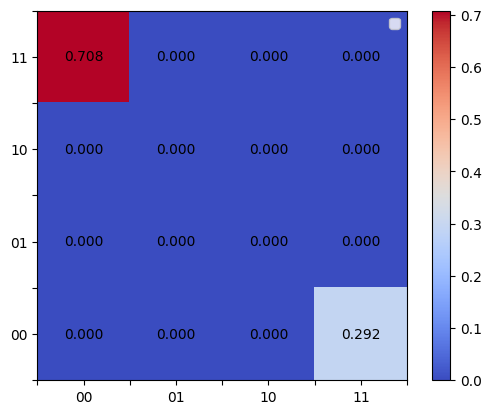

In [196]:
# Real parts

# fig, ax = plt.subplots()
state = ["",'00',"",'01',"",'10',"",'11']
state_y = ["",'11',"",'10',"",'01',"",'00']

# print(state)

fig, ax = plt.subplots()
plt.imshow(rho_real, cmap="coolwarm")
plt.colorbar()
ax.set_xticklabels(state)
ax.set_yticklabels(state_y)
# ax.set_ylabel("qubit 1")
# ax.set_xlabel("qubit 2")
# ax.set_title(r"Target density matrix $\rho_{3}$")


for (j,i),label in np.ndenumerate(rho_real):
    ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
ax.legend()
plt.show()

/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_7273/332766247.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(state)
/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_7273/332766247.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(state_y)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


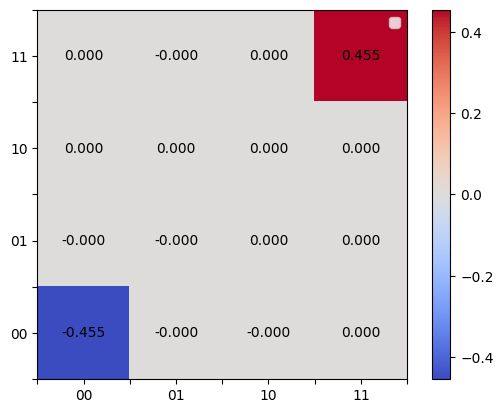

In [197]:
# Im parts

# fig, ax = plt.subplots()
state = ["",'00',"",'01',"",'10',"",'11']
fig, ax = plt.subplots()
plt.imshow(rho_imag, cmap="coolwarm")
plt.colorbar()
ax.set_xticklabels(state)
ax.set_yticklabels(state_y)
# ax.set_ylabel("qubit 1")
# ax.set_xlabel("qubit 2")
# ax.set_title(r"Target density matrix $\rho_{3}$")


for (j,i),label in np.ndenumerate(rho_imag):
    ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
ax.legend()
plt.show()